In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.predict import predict

from omegaconf import open_dict
from hydra import compose, initialize

In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# Training (data taken from starfish MERFISH analysis notebook)
https://spacetx-starfish.readthedocs.io/en/mcai-notebooks-sphinxgallery/gallery/pipelines/merfish_pipeline.html

Load base config. train.yaml contains all hyperparameters, merfish_starfish contains dataset specific information (e.g. number of channels, number of genes, dataset location etc.) that stay fixed across experiments.

In [ ]:
initialize(config_path="config")

In [33]:
cfg = compose(config_name='train.yaml', overrides= ["+exp_type=merfish_starfish"])
cfg = OmegaConf.create(cfg)

Make dataset specific changes

<details><summary>Notes on the MERFISH generative model: **click to expand!** </summary>
    
The basic observation model is given by:
$$Y=DXG+b+\epsilon$$
where Y is the observed multi-channel data, D is the codebook, X is the distribution of transcripts (i.e. the target), G is the PSF and b is additive baseline activity.

Going into more detail these are some additional properties that could be accounted for:
    
1) The data is usually recorded in multiple color channels (here 2, 2 color channels * 8 rounds = 16 bits)
   * This introduces chromatic aberration between the two sets of channels
   * PSFs might be different too
   * We learn separate PSFs (genm.PSF.ncols) as well as chromatic aberration (training.mic.par_grads.color_shifts). 
    
2) There might be small spatial shifts between the color channels (even after alignment during preprocessing)
   * We learn these shifts (training.mic.par_grads.channel_shifts)
    
3) Scaling between channels and colors can vary widely and normalizing it is crucial for performance
   * We can either try to equalize intensities in preprocessing or learn them (training.mic.par_grads.channel_facs)
    
4) As noted in the [supplement](https://www.pnas.org/doi/10.1073/pnas.1612826113) "spot centroids for the same RNA varied in position by ∼100 nm in different imaging rounds, possibly because of the finite cellular volume occupied by each RNA"
   * During simulation we randomly shift the positions across channels for each transcript (genm.microscope.pos_noise_xy / pos_noise_z)
    
5) Just looking at the data we often observe spots that are only visible in single channels and can therefore not be attributed to any code.
   * We simulate such spurious spots with genm.emitter_noise
    
6) At transcription sites we might observe very high local densities of transcripts. (Though these seemed more relevant for smFISH data than for MERFISH?)
   * We simulate such local clusters with the settings in genm.foci. 
    
</details>

In [44]:
# project and run_name set the directories where the trained models are saved, as well as the structure in wandb.ai
cfg.output.project = 'MERFISH_starfish'
cfg.run_name ='MERFISH_sweep_gen_1'

'''Simulation parameters'''
# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.genm.foci.n_foci_avg = 1
# Lower and upper limit of emitters simulated per focus
cfg.genm.foci.n_mol_range: [5,40]                       
    
# Sets the emitter density (range of uniform probabilities for a voxel to contain a transcript)
cfg.genm.prob_generator.low = 0.0002
cfg.genm.prob_generator.high = 0.05

# Sets the intensity distribution of the simulation (parametrizes of a gamma distribution)
cfg.genm.intensity_dist.int_conc = 4.
cfg.genm.intensity_dist.int_rate = 1.
cfg.genm.intensity_dist.int_loc = .5

# Multiplicative overall scaling. Should be adjusted to match the oberved intensity values
cfg.genm.microscope.scale = 60

# Background values are sampled by smoothing the real data
cfg.sim.bg_estimation.smoothing.smoothing_filter_size = 9
cfg.sim.roi_mask.percentile = 20

# In addition to real emitters that are sampled from the codebook (and are visible in multiple channels) we sample spurious 'fake' emitters that only show up in a single channel (to make the network more robust)
cfg.genm.emitter_noise.rate_fac = 3.
cfg.genm.emitter_noise.int_fac = 1.

# Noise on the coordinates of individual transcripts across channels
cfg.genm.microscope.pos_noise_z = 0.04
cfg.genm.microscope.pos_noise_xy = 0.5
cfg.training.z_sig_fac = 2.

cfg.genm.noise.theta = [0.287,0.216,0.377,0.321,0.278,0.255,0.483,0.219,0.616,0.374,0.394,0.358,0.44,0.414,0.447,0.244]
    
'''Performance tracking'''
    
# Crop of the training data that is reconstructed for evaluation
cfg.evaluation.reconstruction.crop_sl = 's_[:,:,1500:1650,150:300]'

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'
cfg.output.log_interval = 500
cfg.evaluation.code_stats.enabled = True

'''Network architecture'''
cfg.network.f_maps = 256
cfg.network.depth = 2
cfg.network.chrom_map = True

'''Training'''
cfg.training.bs = 20
cfg.training.net.opt.lr = 5e-4
cfg.training.mic.norm_reg = 0.

# cfg.training.num_iters = 50000

cfg.training.schedule = [10000, 3000, 5000, 2000, 5000, 2000, 5000, 2000, 5000]
cfg.training.mic.sched.step_size = 2000

# Which parts of the model to train
cfg.training.int.enabled = False
cfg.training.mic.enabled = True
cfg.training.net.enabled = True

cfg.training.mic.par_grads.channel_facs = True
cfg.training.mic.par_grads.channel_shifts = True
cfg.training.mic.par_grads.theta_par = False
cfg.training.mic.par_grads.psf_vol = False
cfg.training.mic.par_grads.color_shifts = True

In [45]:
fname = f'config/experiment/{cfg.run_name}.yaml'
OmegaConf.save(cfg, fname)
prepend_line(fname, '# @package _global_')
cfg.run_name

'MERFISH_sweep_gen_1'

In [46]:
home_dir = os.getenv("HOME")
print(f'bsub -gpu "num=1" -q gpu_rtx -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev2/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name} run_name=no_psf output.group={cfg.run_name}')

bsub -gpu "num=1" -q gpu_rtx -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=MERFISH_sweep_gen_1 run_name=no_psf output.group=MERFISH_sweep_gen_1


In [10]:
tra = load_tiff_image(sorted(glob.glob(cfg.data_path.image_path))[0])

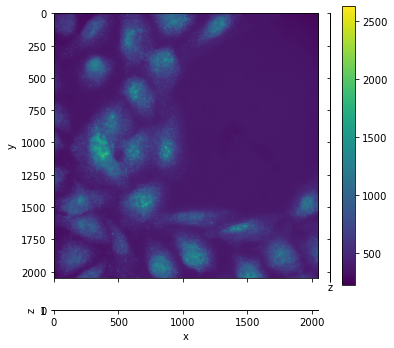

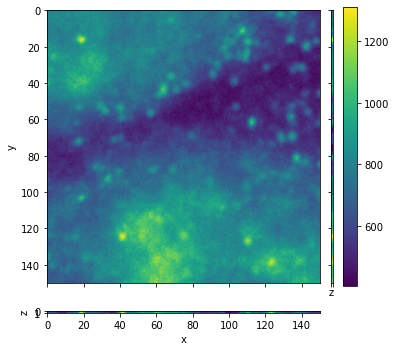

In [8]:
img = load_tiff_image(sorted(glob.glob(cfg.data_path.image_path))[0])[0][None]
_ = plot_3d_projections(img, size=5, proj_func=np.max)
sl = eval(cfg.evaluation.reconstruction.crop_sl,{'__builtins__': None},{'s_': np.s_})
_ = plot_3d_projections(img[sl[:]], size=5)

In [76]:
from scipy import stats
def estimate_noise_scale(img, bg_est, percentile=99, plot=True):
    """ Returns an estimate of theta given a volume and a background estimate 
    
    Args:
        img: recorded volume for which we want to estimate the noise 
        bg_est: estimated background for img
        percentile: we wan't to exclude the signal for our fit. therefore we only use the lower percentile of all voxels
        plot: whether to plot the data and the final fit
        
    Returns:
        fit_theta: theta estimate
    """
    
    img = cpu(img)
    bg_est = cpu(bg_est)
    residual = np.clip(img - bg_est + bg_est.mean(), img.min(), 1e10)
    fit_vals = residual[residual < np.percentile(residual, percentile)]
    fit_vals = fit_vals[fit_vals > np.percentile(fit_vals, 100-percentile)]
    fit_alpha, fit_loc, fit_theta=stats.gamma.fit(fit_vals, floc=0)   

    if plot:
        _ = plt.hist(fit_vals,bins=np.linspace(fit_vals.min(),fit_vals.max(), 51),  histtype ='step',label='data', density=True)
        x = np.linspace(fit_vals.min(),fit_vals.max(),101)
        y = stats.gamma.pdf(x, fit_alpha, fit_loc, fit_theta)
        plt.plot(x, y, label='Fit')
        plt.legend()
        
    return fit_theta

In [77]:
img = load_tiff_image(cfg.data_path.image_path)
thetas = []
for i in range(16):
    bg_est = hydra.utils.instantiate(cfg.bg_estimation.smoothing)(img[i,:,:500,1500:].to('cuda'))
    theta = estimate_noise_scale(img[i,:,:500,1500:], bg_est, percentile=99, plot=False)
#     plt.show()
    thetas.append(theta)

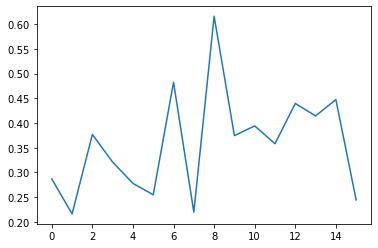

In [78]:
plt.plot(thetas)

In [86]:
dd

0.0005

Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [460]:
n_foci = cfg.foci.n_foci_avg
cfg.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)
cfg.foci.n_foci_avg = n_foci

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


(<Figure size 701.486x658.286 with 6 Axes>,
 [<AxesSubplot:ylabel='y'>,
  <AxesSubplot:xlabel='x', ylabel='z'>,
  <AxesSubplot:xlabel='z'>])

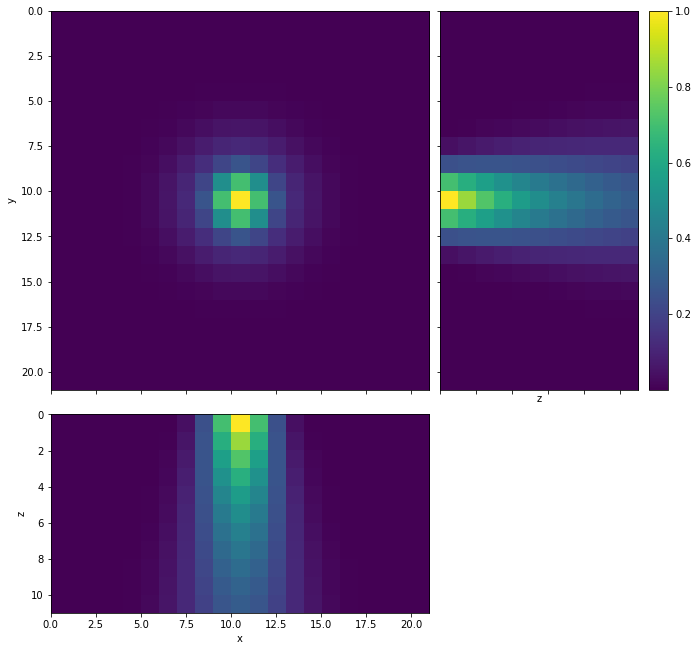

In [461]:
plot_3d_projections(torch.tensor(psf.psf_volume)[0])

This function allows you to visually compare the recorded data and the simulations generated with the given config.  
For each sample we plot a slice from the input volume and from a simulated training volume as well as the estimated background.  
In the second row we compare maximum intensity projections.  

Adjust the microscope.scale and PSF.gauss_radii until you achieve a rough match in intensities and the PSF shape.  
You don't have to get this exactly right as these values get automatically fine tuned during training.
It is totally fine if average density of emitters in the simulations is higher than in the recordings.

In [48]:
# get_simulation_statistics(decode_dl, micro, **cfg.genm.intensity_dist, int_threshold=0.1, samples=10, channels=cfg.genm.exp_type.n_channels, n_bits=cfg.genm.exp_type.n_bits, psf_noise=False, codebook=torch.tensor(code_ref))

# Evaluation

In [36]:
# cfg.run_name = 'test'
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_1/None//train.yaml')

In [37]:
# cfg.exp_type.pred_z=False
# cfg.PSF.psf_extent_zyx=[1,21,21]

In [38]:
from decode_fish.funcs.exp_specific import *
bench_df, code_ref, targets = get_benchmark()
code_inds = np.stack([np.nonzero(c)[0] for c in code_ref])

13832


In [39]:
# cfg.exp_type.pred_z = False

In [40]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_init = get_vol_psf(cfg.data_path.psf_path, device='cuda', psf_extent_zyx=None)
psf_init = cpu(psf_init.psf_volume)
psf_vol = cpu(micro.psf.psf_volume)
post_proc.codebook = torch.tensor(code_ref)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Plot mean projections of the PSF before and after optimizing it during training

(tensor(2.5238, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0114, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0087, device='cuda:0', grad_fn=<DivBackward0>))


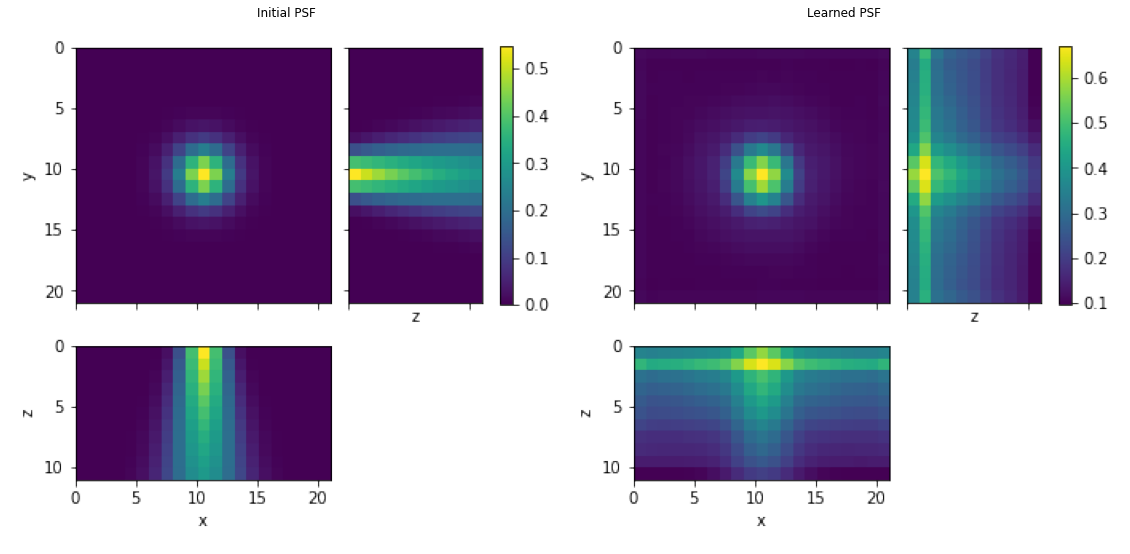

In [41]:
print(micro.psf.get_com())
fig1,_ =plot_3d_projections(psf_init[0], proj_func=np.mean, size=3, display=False)
fig2,_ =plot_3d_projections(psf_vol[0], proj_func=np.mean, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(20,10))

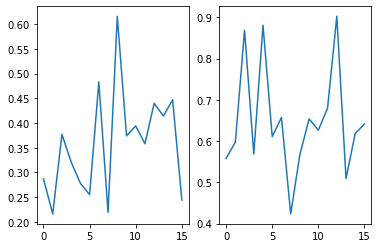

In [42]:
plt.subplot(121)
plt.plot(cpu(micro.noise.theta_par.to('cpu')*micro.noise.theta_scale))
plt.subplot(122)
plt.plot(cpu(micro.channel_facs.to('cpu')))

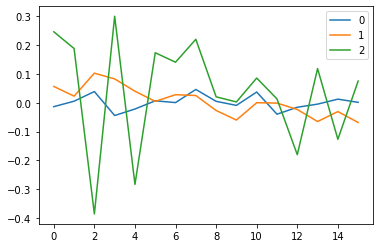

In [43]:
for i in range(3):
    plt.plot(cpu(micro.noise.channel_shifts[:,i]), label=i)
plt.legend()

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

15


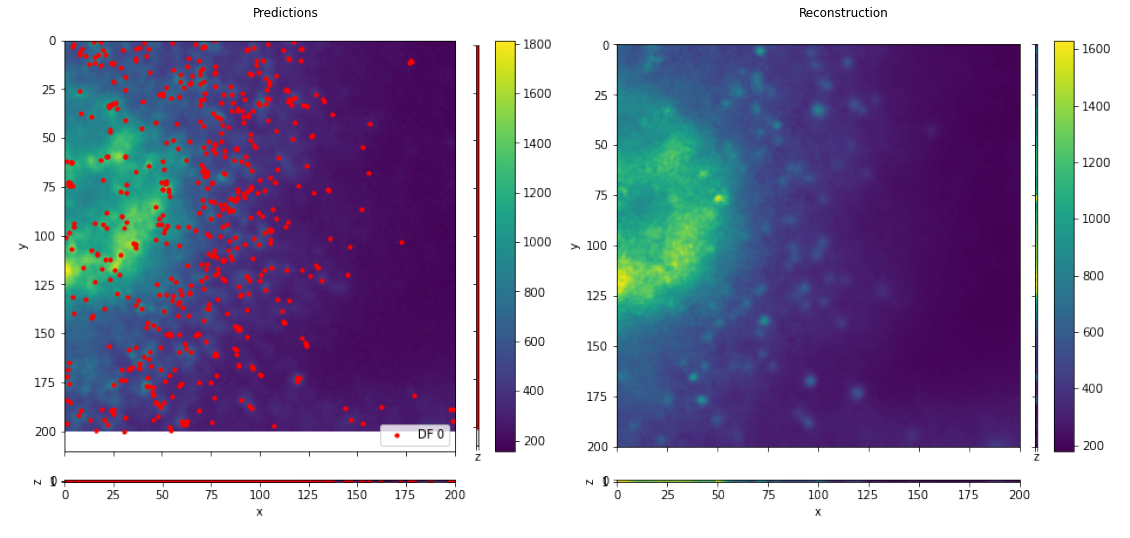

ValueError: too many values to unpack (expected 4)

In [41]:
x, pred_df, rec, res_dict = eval_random_crop(decode_dl, model, post_proc, micro, samples=10, plot='rec', crop_sz_xy=200, ret_preds=True)

In [223]:
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *

def sim_data(decode_dl, batches, micro, model, channels=1, n_bits=1, sim_z=True, codebook=None):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        with torch.no_grad():
            x, local_rate, background = next(iter(decode_dl))
            sim_vars = PointProcessUniform(local_rate[:,0] ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=channels, n_bits=n_bits, sim_z=sim_z, codebook=codebook, int_option=cfg.training.int_option).sample(from_code_book=(codebook is not None))
            ch_inp = micro.get_single_ch_inputs(*sim_vars[:-1])
            xsim = micro(*ch_inp, add_noise=True, add_pos_noise=True)


            noise_vars = PointProcessUniform(local_rate[:,0] * cfg.genm.emitter_noise.rate_fac, int_conc=model.int_dist.int_conc.detach() * cfg.genm.emitter_noise.int_fac, 
                                           int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                           sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=1, 
                                           sim_z=cfg.genm.exp_type.pred_z, codebook=None, int_option=cfg.training.int_option).sample(from_code_book=False)     

            noise_inp = micro.get_single_ch_inputs(*noise_vars[:-1])
            xsim += micro(*noise_inp, add_noise=True)
        
            x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

            xsim_col.append(x)

            gt_vars = sim_vars[:-2] 
            gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
            gt_dfs.append(gt_df)
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        with torch.no_grad():
#             pred_df, rec, res_dict, _, _, _, _ = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True)
            pred_df = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=False)
            pred_dfs.append(pred_df)
#             x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
#     xrec = torch.cat(x_recs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=1000, print_res=print_res, match_genes=True, allow_multiple_matches=True)
#     perf['mae'] = abs(xrec-rec).mean().item()
#     perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    res_dict = None
    return perf, pred_df, matches, res_dict

In [224]:
# from decode_fish.funcs.routines import *
xsim, gt = sim_data(decode_dl, 100, micro, model, channels=16, n_bits=4, sim_z=cfg.genm.exp_type.pred_z, codebook=torch.tensor(code_ref))
# perf, pred_df, matches, res_dict = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)pred_df

In [225]:
perf, pred_df, matches, res_dict = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

Recall: 0.505
Precision: 0.959
Jaccard: 49.407
RMSE_vol: 57.567
Eff_3d: 41.792
FN: 77316.0 FP: 3356.0
Num. matches: 78781.000
Shift: -0.21,-0.10,1.29


In [226]:
pred_df.loc[:, 'class'] = 1
pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0

In [227]:
pred_df['tot_int'] = pred_df['int_0']+pred_df['int_1']+pred_df['int_2']+pred_df['int_3']
pred_df['tot_int_sig'] = pred_df['int_sig_0']+pred_df['int_sig_1']+pred_df['int_sig_2']+pred_df['int_sig_3']

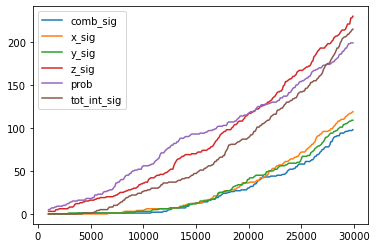

In [228]:
def make_roc(df, var='code_err', ascending=True, n_max=30000):
    
    if n_max is None:
        n_max = len(df)
    x = np.arange(1000,n_max,100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append((df[:int(i)]['class']==1).sum())
        
    return x, n_blanks

for k in ['comb_sig','x_sig','y_sig','z_sig','prob','tot_int_sig']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(pred_df, k, n_max=30000, ascending=b)
    plt.plot(r[0],r[1], label=k)
plt.legend()

If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [229]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

keys = ['x_sig','y_sig','z_sig','prob']

X = np.concatenate([pred_df[keys].values])
y = np.concatenate([pred_df['class'].values])
 
clf = LogisticRegressionCV(random_state=1,max_iter=10000, class_weight='balanced').fit(X, y)

In [230]:
X = np.concatenate([pred_df[keys].values])
pred_df['score'] = clf.predict_proba(X)[:,1]

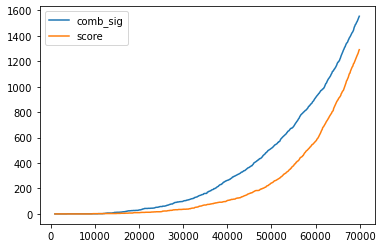

In [231]:
for k in ['comb_sig','score']:
    r  = make_roc(pred_df, k, n_max=70000, ascending=True)
    plt.plot(r[0],r[1], label=k)
plt.legend()

In [282]:
clf.coef_[0]

array([ 0.05370561,  0.05380239,  0.03767978, -3.79047279])

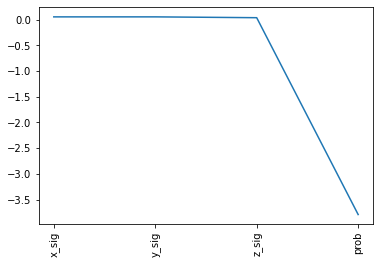

In [232]:
plt.plot(clf.coef_[0])
_ = plt.xticks(ticks=np.arange(len(keys)),labels=keys, rotation=90)

In [233]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_14/int_option:1//train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_14c/loss_option:1xcount_mult:0xcat_logits:0/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_sl_19b/start_mic:200000xstart_int:200000xrate_fac:0xn_dump_codes:0xbs:3/train.yaml')

In [234]:
# cfg.output.save_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/nb_run/test/'

In [182]:
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [183]:
# for p in micro.parameters():
# #     p.requires_grad = False
#     print(p, p.requires_grad)

In [271]:
from decode_fish.funcs.predict import *

res_df = merfish_predict(model, post_proc, [cfg.data_path.image_path], window_size=[None, 256, 256], device='cuda')
res_df = exclude_borders(res_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])

torch.Size([16, 1, 2048, 2048])


100%|██████████████████████████████████████████████████████████████| 1/1 [00:40<00:00, 40.31s/it]


In [272]:
from decode_fish.funcs.merfish_eval import *
bench_df, code_ref, targets = get_benchmark()
bench_df = bench_df[bench_df['gene'] != 'MALAT1']

13832


In [273]:
# from decode_fish.funcs.predict import *
# image_paths = sorted(glob.glob(cfg.data_path.image_path))
# image_paths = ['/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled//img_stack.tiff']
# inf_dfs = merfish_predict(model, post_proc, image_paths=image_paths, window_size=[None, 256, 256], device='cuda')
# # inf_df.to_csv(f'../data/results/MERFISH/test.csv', index=False)

In [274]:
# res_df = exclude_borders(inf_dfs, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])
res_df['gene'] = targets[res_df['code_inds']]
res_df = res_df[res_df['gene'] != 'MALAT1'] 
res_df['x'] += 100
res_df['y'] += 100

In [275]:
res_single = remove_doublets(res_df, tolerance=200)
print(len(res_single)/len(res_df))

0.8637074177849875


In [276]:
# res_df1.to_csv(f'../data/results/MERFISH/test.csv', index=False)

In [239]:
matches2, bench_match = match_bench(res_df, bench_df)

[3.403080898286255, 2.778012666094685, 0.4690394759366983]
Recall: 0.905
Precision: 0.332
Jaccard: 32.054
RMSE_vol: 85.345
Eff_3d: 19.765
FN: 1190.0 FP: 22901.0
Num. matches: 11365.000
Shift: 0.01,0.03,0.00


In [31]:
bench_counts = DF(data=None, index=targets)
bench_counts['Res_all'] = res_df.groupby('gene')['gene'].count()
bench_counts['Bench_all'] = bench_df.groupby('gene')['gene'].count()
bench_counts = bench_counts.fillna(0)
r = np.corrcoef(bench_counts['Bench_all'].values, bench_counts['Res_all'].values)[0, 1]   

12555 33905


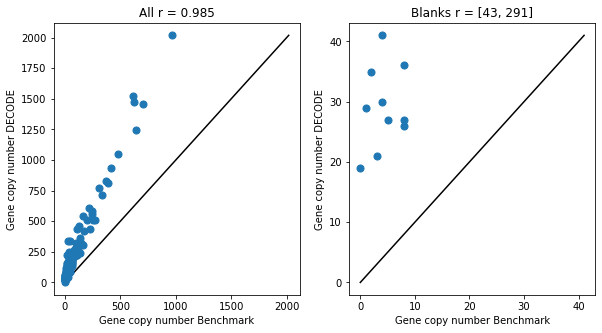

In [277]:
plot_gene_panels(res_df, bench_match, targets)

12555 15000


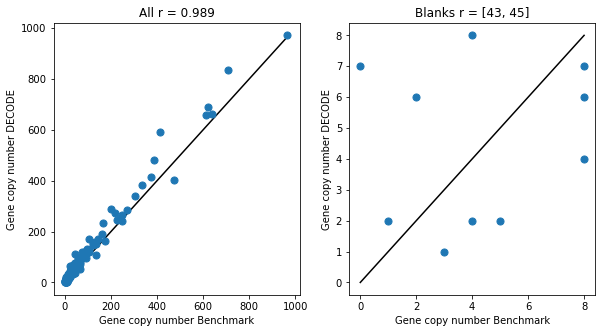

In [278]:
plot_gene_panels(res_single.nsmallest(15000, 'comb_sig'), bench_match, targets)

12555 17500


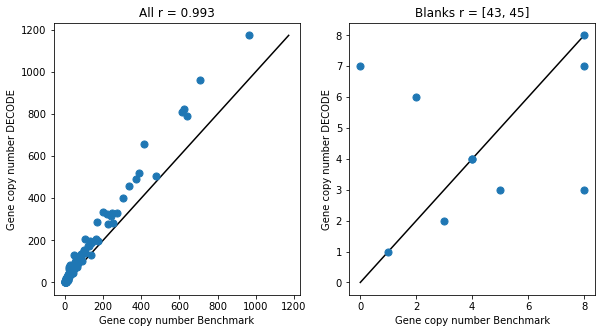

In [281]:
plot_gene_panels(res_single.nsmallest(17500, 'score'), bench_match, targets)

In [279]:
X = np.concatenate([res_single[keys].values])
res_single['score'] = clf.predict_proba(X)[:,1]

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def make_roc(df, var='code_err', ascending=True, n_max=50000):
    
    if n_max is None:
        n_max = len(df)
    x = np.arange(1000,n_max,100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append((df[:int(i)]['gene'].str.contains('Blank')).sum())
        
    return x, n_blanks

for k in ['comb_sig','score']:
    r  = make_roc(res_single, k, n_max=20000, ascending=True)
    plt.plot(r[0],r[1], label=k)
plt.legend()

[autoreload of torch failed: Traceback (most recent call last):
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/groups/turaga/home/speis

In [99]:
res_df1.to_csv(f'../data/results/MERFISH/test.csv', index=False)

In [599]:
img_stack_o = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish/img_stack.tiff')
img_stack_s = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled//img_stack.tiff')

In [227]:
# sl = np.s_[0,700:1200,300:800]
# # malat = 7,  8, 13, 14
# for i in range(16):

#     plt.figure(figsize=(20,8))
#     im = plt.imshow(img_stack[i][sl])
#     add_colorbar(im)

In [604]:
sl = np.s_[:,:,500:1250,1100:1700]
sl = np.s_[:,:,:,:]
img = load_tiff_image(image_paths[0])
for i in range(16):

    preds_px = nm_to_px(inf_df[inf_df['frame_idx']==(i)])
    plt.figure(figsize=(25,25))
    im = plt.imshow(img[i,0][sl[2:]])
    add_colorbar(im)
    sub_preds = crop_df(preds_px, sl)
    plt.scatter(sub_preds['x'],sub_preds['y'], color='red', s=3.5)
    plt.show()

TypeError: 'NoneType' object is not subscriptable

In [255]:
import mpld3
from mpld3 import plugins
code_cols = [plt.get_cmap('gist_ncar')(x) for x in np.linspace(0.,1.,140)]

29555


(600.0, 750.0)

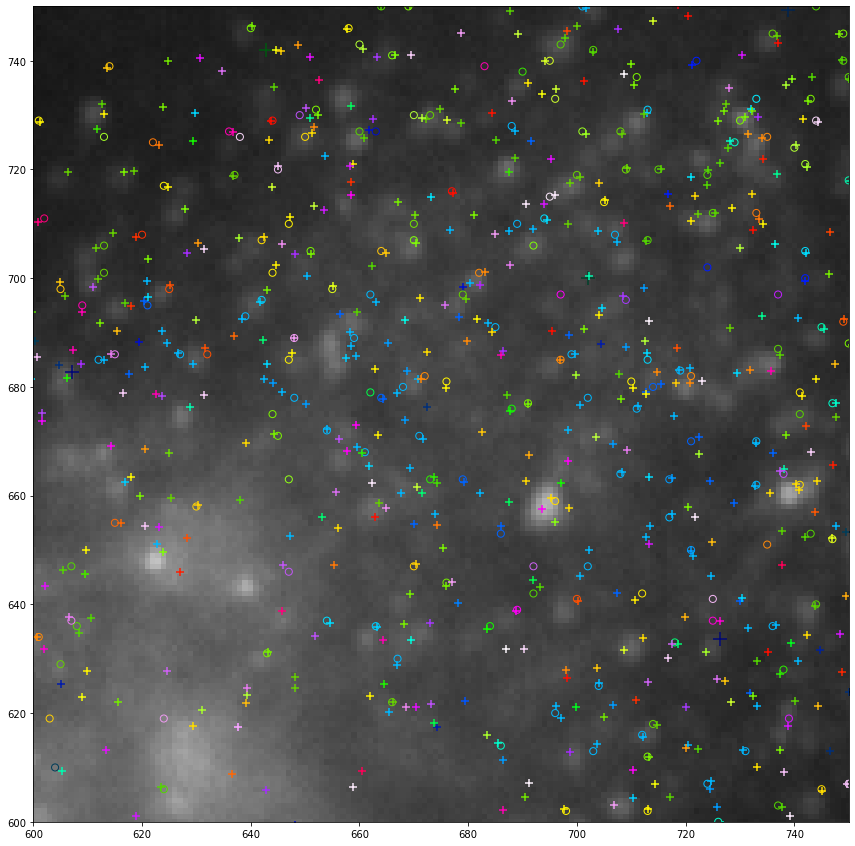

In [256]:
ind = 0
img = load_tiff_image(cfg.data_path.image_path)
preds_px = nm_to_px(res_single)#[res_df['gene']!='MALAT1']
bench_px = nm_to_px(bench_df)#[bench_df['gene']!='MALAT1']
print(len(preds_px))
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img[0,0], cmap='gray')

for i in range(len(targets)):
    
    preds_sub = preds_px[preds_px['code_inds'] == i]
    bench_sub = bench_px[bench_px['code_inds'] == i]
    
    size = 200. if 'Blank' in targets[i] else 50.

    ax.scatter(bench_sub['x'],bench_sub['y'], color=code_cols[i], s=size, marker='o', facecolor='none')
    ax.scatter(preds_sub['x'],preds_sub['y'], color=code_cols[i], s=size, marker='+')

ax.set_xlim(600,750)
ax.set_ylim(600,750)

# plugins.connect(fig, plugins.MousePosition(fontsize=14))
# mpld3.display()

In [254]:
for i in range(4):
    for j in range(i+1,4):
        print(i,j,np.corrcoef(res_single[f'int_{i}'], res_single[f'int_{j}'])[0,1])

0 1 0.07120999857339837
0 2 0.1351865230633996
0 3 -0.09645277830978242
1 2 -0.07322307972781757
1 3 -0.0242176467533459
2 3 0.0977937502311161


In [262]:
int_keys = [f'int_{i}' for i in range(4)]
ints = res_single.loc[:,int_keys].values

Text(0.5, 0, 'four highest probablities')

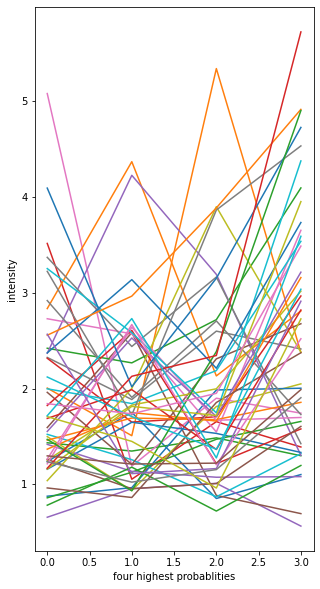

In [264]:
plt.figure(figsize=(5,10))
for i in range(100,150):
    plt.plot(ints[i])
plt.ylabel('intensity')
plt.xlabel('four highest probablities')